In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

Set path to simulation directory and files:

In [12]:
@dataclass(frozen=True)
class SimulationPaths:
    
    base: Path = Path("/group/ag_compstatphys/data/tolga/simulation")
    obstacle: Path = base / "crystalline_walls_W15_rho0.8.h5"
    thermalization: Path = base / "slit_pore__equilibration_D15_rho0.7_T1.00_20251024_180624.h5"
    production_NVE: Path = base / "slit_pore__production_D15_rho0.7_T1.00_20251025_155550.h5"
    production_NVT: Path = base / "slit_pore__production_NVT_D15_rho0.7_T1.00_20251025_203202.h5"
    lj_bulk: Path = base / "lj_production_T1_0_rho_0_7.h5"

paths = SimulationPaths()

In [13]:
class Simulation:
    def __init__(self, path):
        self.path = path
        self._file = None

    def __enter__(self):
        self._file = h5py.File(self.path, 'r')
        return self

    def __exit__(self, *args):
        self._file.close()

    def potential_energy(self):
        potential_energy = np.array(self._file['observables/potential_energy/value'])
        time = np.array(self._file['observables/potential_energy/time'])
        return np.stack((potential_energy, time))
    
    def pressure(self):
        pressure = np.array(self._file['observables/pressure/value'])
        time = np.array(self._file['observables/pressure/time'])
        return np.stack((pressure, time))
    
    def stress_tensor(self):
        return np.array(self._file['observables/stress_tensor/value'])
    
    def temperature(self):
        temperature = np.array(self._file['observables/temperature/value'])
        time = np.array(self._file['observables/temperature/time'])
        return np.stack((temperature, time))
    
    def slab_stress_tensor_sampled(self):
        # Calculate time averaged stress tensor over slabs

        region_list = list(self._file['thermo'].keys())
        num_regions = len(region_list)
    
        stress_tensor_sampling = np.zeros((num_regions,6))
        for i in range(1, num_regions + 1):
            dataset_path = f'thermo/slab_{i}/stress_tensor/value'
            cur_data = self._file[dataset_path]     
            stress_tensor_sampling[i - 1] += np.mean(cur_data)
        
        return stress_tensor_sampling


    def slab_density_sampled(self):
        # Calculate time averaged density over slabs

        region_list = list(self._file['thermo'].keys())
        num_regions = len(region_list)
    
        density_sampling = np.zeros(num_regions)
        for i in range(1, num_regions + 1):
            dataset_path = f'thermo/slab_{i}/density/value'
            cur_data = self._file[dataset_path]     
            density_sampling[i - 1] += np.mean(cur_data)
        
        return density_sampling
    

In [14]:
with Simulation(paths.thermalization) as sim:
    T_thermalization = sim.temperature()
    U_thermalization = sim.potential_energy()

with Simulation(paths.production_NVE) as sim:
    T_production_NVE = sim.temperature()
    U_production_NVE = sim.potential_energy()

with Simulation(paths.production_NVT) as sim:
    T_production_NVT = sim.temperature()
    U_production_NVT = sim.potential_energy()

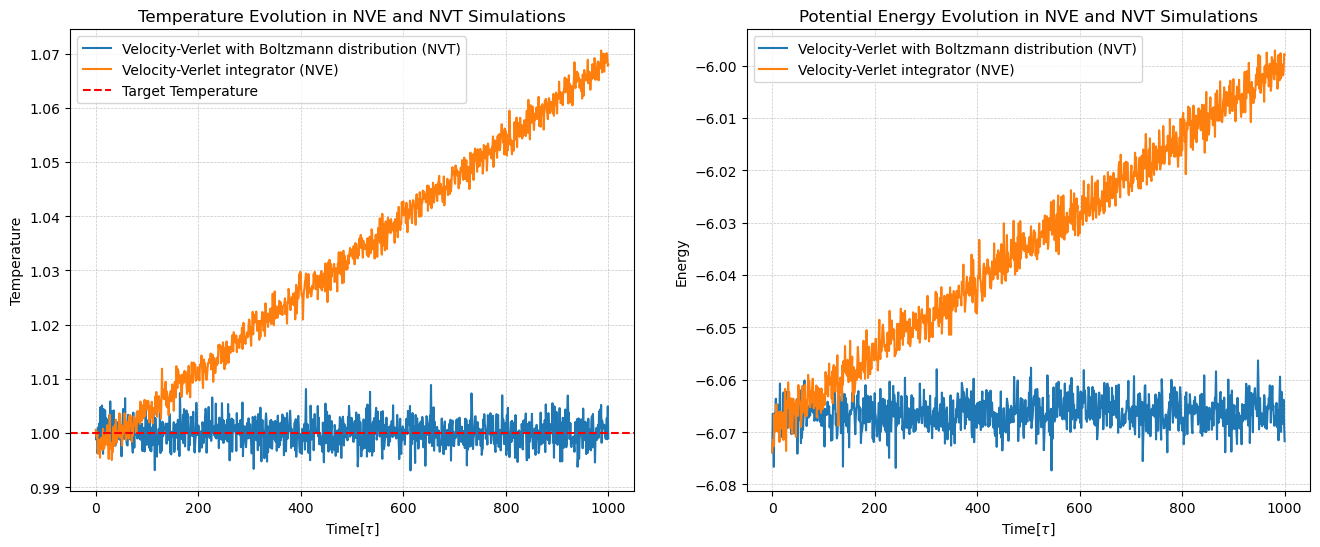

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#Temperature Plot

ax1.plot(T_production_NVT[1], T_production_NVT[0], label = 'Velocity-Verlet with Boltzmann distribution (NVT)')
ax1.plot(T_production_NVE[1], T_production_NVE[0], label = 'Velocity-Verlet integrator (NVE)')

ax1.axhline(1.0, ls = '--', color = 'red', label = 'Target Temperature')

ax1.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.legend()

ax1.set_title('Temperature Evolution in NVE and NVT Simulations')

ax1.set_xlabel(r'Time$[\tau]$')
ax1.set_ylabel('Temperature')

#Potential Energy Plot

ax2.plot(U_production_NVT[1], U_production_NVT[0], label = 'Velocity-Verlet with Boltzmann distribution (NVT)')
ax2.plot(U_production_NVE[1], U_production_NVE[0], label = 'Velocity-Verlet integrator (NVE)')


ax2.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.legend()

ax2.set_title('Potential Energy Evolution in NVE and NVT Simulations')

ax2.set_xlabel(r'Time$[\tau]$')
ax2.set_ylabel('Energy')



plt.show()


In [16]:
with Simulation(paths.production_NVT) as sim:
    slab_density_NVT = sim.slab_density_sampled()

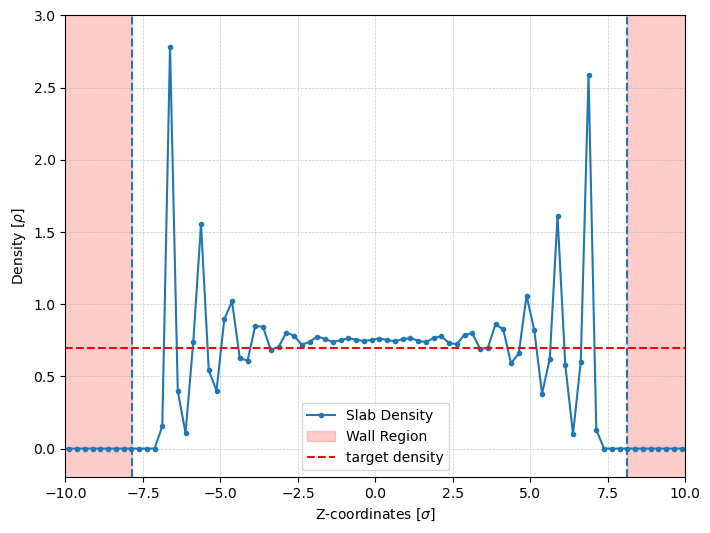

In [17]:
plt.figure(figsize=(8, 6))


slab_width = 0.25


y = slab_density_NVT
x = np.linspace(-15, 15 - slab_width , y.shape[0]) + slab_width/2.0

plt.plot(x,y, '-o', markersize = 3, label = 'Slab Density')
    
plt.axvline(-7.857, ls = '--')
plt.axvline(8.109, ls = '--')

plt.title("Density Profile")
plt.xlabel(r'Z-coordinates $[\sigma]$')
plt.ylabel(r"Density $[\rho]$")


#plt.axvline(-1.25, ls = '--')
#plt.axvline(1.25, ls = '--')

plt.fill_between((-15, -7.857), -5, 5, color='red', alpha=0.2, label = 'Wall Region')
plt.fill_between((8.109, 15), -5, 5, color='red', alpha=0.2)

#plt.fill_between((-1.25, 1.25), -5, 5, color='gray', alpha=0.5, label = 'Calculation Region')
plt.axhline(0.7, color = 'red', linestyle = '--' ,label = 'target density')
plt.legend()
plt.ylim(-0.2, 3)
plt.xlim(-10,10)


plt.title('')



plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()


plt.show()

Extend Simulation class to read wavevectors, wavenumbers and static structure factor:

In [18]:
class Simulation(Simulation):
    # Read wavenumbers from simulation file:
    def wavenumber_slab_parallel(self):
        return np.array(self._file['ssf/slab_1/parallel/wavenumber'])

    def wavenumber_slab_perpendicular(self):
        return np.array(self._file['ssf/slab_1/perpendicular/wavenumber'])
    
    def wavenumber_bulk_parallel(self):
        return np.array(self._file['ssf/global_parallel/bulk/wavenumber'])
    
    def wavenumber_bulk_perpendicular(self):
        return np.array(self._file['ssf/global_perpendicular/bulk/wavenumber']) 



    # Read SSF from simulation file:
    def ssf_slab_parallel(self):
        region_list = list(self._file['ssf'].keys())
        num_regions = len(region_list)
        num_regions -= 2

        ssf_shape = self._file['ssf/slab_1/parallel/value'].shape
        # Calculate time averaged static structure factor
        ssf_parallel = np.zeros((num_regions, ssf_shape[1], ssf_shape[2]))

        for i in range(1, num_regions + 1):
            dataset_parallel_path = f'ssf/slab_{i}/parallel/value'
            ssf_parallel_cur = np.array(self._file[dataset_parallel_path])
            ssf_parallel[i - 1] = np.average(ssf_parallel_cur, axis = 0)
            
        return ssf_parallel

    def ssf_slab_perpendicular(self):
        region_list = list(self._file['ssf'].keys())
        num_regions = len(region_list)
        num_regions -= 2

        ssf_shape = self._file['ssf/slab_1/perpendicular/value'].shape
        # Calculate time averaged static structure factor
        ssf_perpendicular = np.zeros((num_regions, ssf_shape[1], ssf_shape[2]))

        for i in range(1, num_regions + 1):
            dataset_parallel_path = f'ssf/slab_{i}/perpendicular/value'
            ssf_perpendicular_cur = np.array(self._file[dataset_parallel_path])
            ssf_perpendicular[i - 1] = np.average(ssf_perpendicular_cur, axis = 0)
            
        return ssf_perpendicular
    
    def ssf_bulk_parallel(self):
        return np.average(self._file['ssf/global_parallel/bulk/value'], axis = 0)

    def ssf_bulk_perpendicular(self):
        return np.average(self._file['ssf/global_perpendicular/bulk/value'], axis = 0)

In [19]:
with Simulation(paths.production_NVT) as sim:
    ssf_bulk_parallel_NVT = sim.ssf_bulk_parallel()
    wavenumber_bulk_parallel_NVT = sim.wavenumber_bulk_parallel()
    ssf_slab_parallel_NVT = sim.ssf_slab_parallel()

In [23]:
data_folder = '/group/ag_compstatphys/data/tolga/walls'
def read_ssf_obs(file_name, structure):

    file_path = f'{data_folder}/{file_name}'
 

    with h5py.File(file_path, 'r') as sim_data:

        wavenumber = np.array(sim_data[f'ssf/{structure}/wavenumber'])
        
        # Calculate time averaged static structure along simulation box
        ssf = np.zeros((wavenumber.shape[0], 3))

        ssf = sim_data[f'ssf/{structure}/value']
        ssf_mean = np.average(np.array(ssf), axis = 0)

    return wavenumber, ssf_mean
    
wavenumber_obs, ssf_obs = read_ssf_obs("crystalline_walls_100_W15_rho3_ssf.h5", "parallel")

#plt.xscale("log")

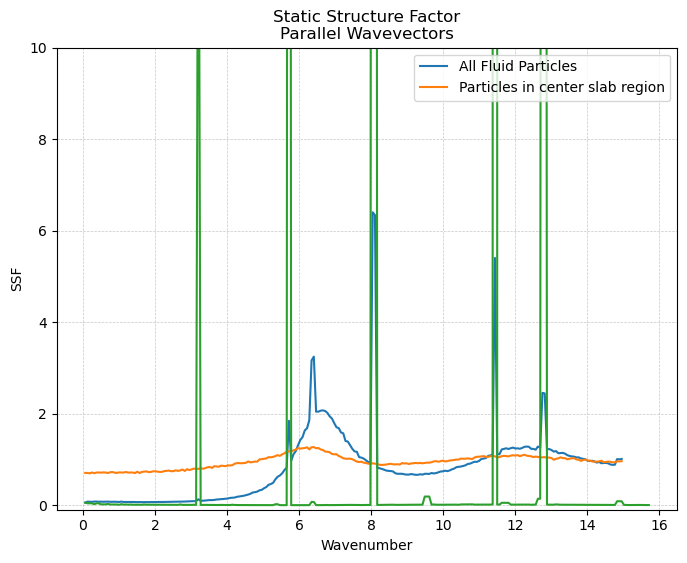

In [29]:
plt.figure(figsize=(8, 6))


slab_width = 0.25


y = slab_density_NVT
x = np.linspace(-15, 15 - slab_width , y.shape[0]) + slab_width/2.0

plt.plot(wavenumber_bulk_parallel_NVT, ssf_bulk_parallel_NVT[:,0], markersize = 3, label = 'All Fluid Particles')
plt.plot(wavenumber_bulk_parallel_NVT, ssf_slab_parallel_NVT[60,:,0], markersize = 3, label = 'Particles in center slab region')

plt.plot(wavenumber_obs[:250], ssf_obs[:250, 0])


plt.title(f'Static Structure Factor\nParallel Wavevectors')
plt.xlabel('Wavenumber')
plt.ylabel('SSF')

plt.ylim(-0.1, 10)

plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()

plt.show()

In [21]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

def smooth_1d(y, method='gaussian', window=11, sigma=2, polyorder=3):
    """
    Smooth 1D data.

    Parameters
    ----------
    y : array_like
        Input 1D data (noisy signal).
    method : str, optional
        Smoothing method: 'moving', 'gaussian', or 'savgol' (default: 'gaussian').
    window : int, optional
        Window length for moving average or Savitzky–Golay filter (must be odd).
    sigma : float, optional
        Standard deviation for Gaussian filter.
    polyorder : int, optional
        Polynomial order for Savitzky–Golay filter.

    Returns
    -------
    y_smooth : np.ndarray
        Smoothed signal.
    """
    y = np.asarray(y)
    if y.ndim != 1:
        raise ValueError("Input must be 1D.")

    if method == 'moving':
        if window < 1:
            raise ValueError("window must be >= 1")
        kernel = np.ones(window) / window
        y_smooth = np.convolve(y, kernel, mode='same')

    elif method == 'gaussian':
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')

    elif method == 'savgol':
        # window must be odd and >= polyorder + 2
        if window % 2 == 0:
            window += 1
        y_smooth = savgol_filter(y, window_length=window, polyorder=polyorder)

    else:
        raise ValueError("method must be 'moving', 'gaussian', or 'savgol'")

    return y_smooth
